2. Geographic Analysis


In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

<hr style="border: 1px solid #ccc; margin: 20px 0;">

**•	Which cities have the highest and lower number of accidents?**


The first 5 cities with the most incidents are:
Miami (186917)
Houston (169609)
Los Angeles (156491)
Charlotte (138652)
Dallas (130939)

The cities with the least incidents are:
Willow City (1)
Window Rock (1)
Wingina (1)
Yeso (1)
Young (1)

Has duplicates: <dask_expr.expr.Scalar: expr=(DropDuplicates(frame=ReadParquetFSSpec(4abb328)['City'], split_every=False)).count() < 7728394, dtype=bool>


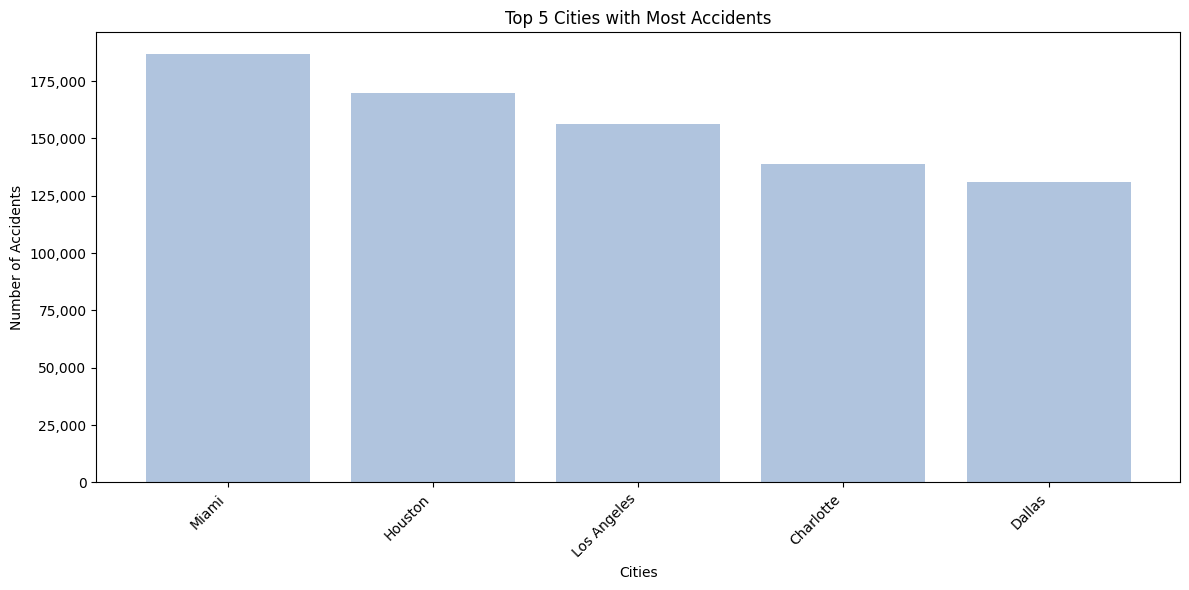

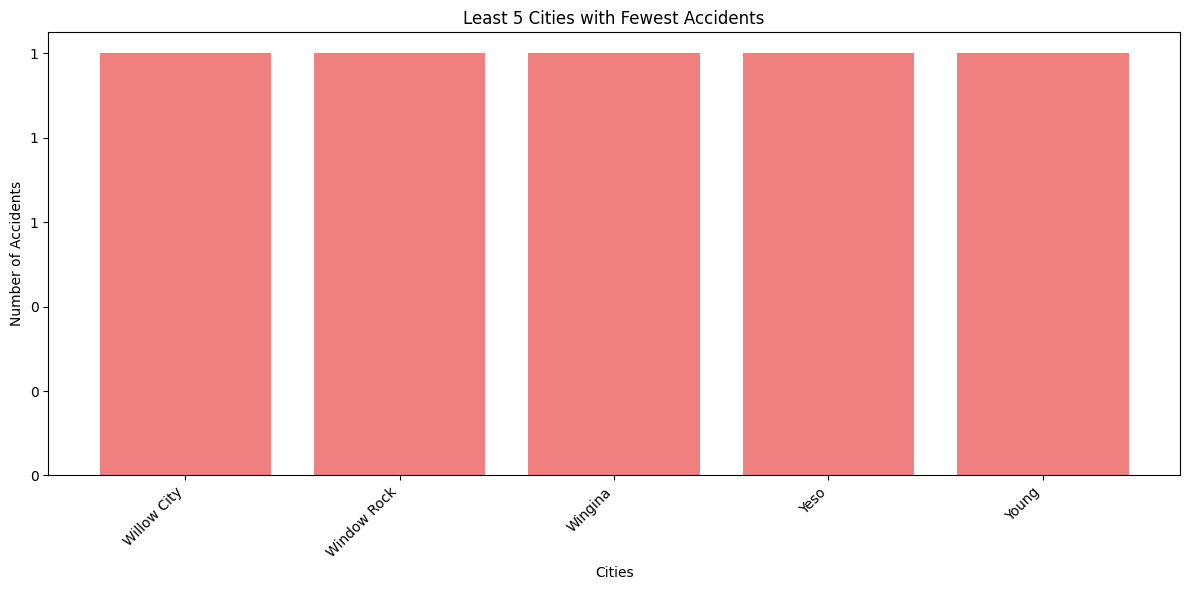

In [1]:
# Load the Dask DataFrame
df = dd.read_parquet('Data/Parquet/US_Accidents_March23.parquet')

# Count accidents for each city
city_counts = df['City'].value_counts().compute()  # Get counts directly

# Sort the city counts in descending order
sorted_city_counts = city_counts.sort_values(ascending=False)

# Get the top 5 cities with the most incidents
top_5_cities = sorted_city_counts.head(5)

# Get the bottom 5 cities with the least incidents
least_5_cities = sorted_city_counts.tail(5)

# Print the results
print("The first 5 cities with the most incidents are:")
for city, count in top_5_cities.items():
    print(f"{city} ({count})")

print("\nThe cities with the least incidents are:")
for city, count in least_5_cities.items():
    print(f"{city} ({count})")

# Check for duplicates
has_duplicates = df['City'].nunique() < len(df['City'])

# Print sorted results
print("\nHas duplicates:", has_duplicates)

# Plotting the top 5 cities
plt.figure(figsize=(12, 6))
plt.bar(top_5_cities.index, top_5_cities.values, color='lightsteelblue')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Cities')
plt.ylabel('Number of Accidents')
plt.title('Top 5 Cities with Most Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the least 5 cities
plt.figure(figsize=(12, 6))
plt.bar(least_5_cities.index, least_5_cities.values, color='lightcoral')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Cities')
plt.ylabel('Number of Accidents')
plt.title('Least 5 Cities with Fewest Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<hr style="border: 1px solid #ccc; margin: 20px 0;">

**•	Which regions or states have the highest accident severity?**

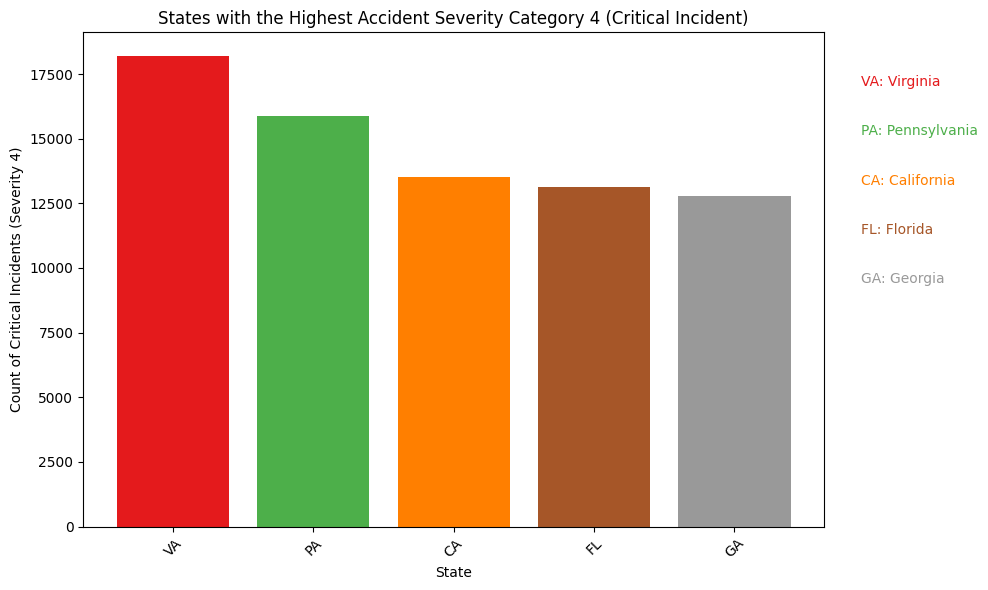

In [2]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np

# Dictionary to map state abbreviations to full names
state_names = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Load the Dask DataFrame
df = dd.read_parquet('Data/Parquet/US_Accidents_March23.parquet')

# Group by 'State' and 'Severity' and count the occurrences of each
state_severity_counts = df.groupby(['State', 'Severity']).size()

# Compute the result
result = state_severity_counts.compute()

# Convert to a Pandas DataFrame for easier manipulation
result_df = result.reset_index(name='Count')

# Filter the DataFrame for Severity 4 (Critical Incidents)
severity_4_df = result_df[result_df['Severity'] == 4]

# Sort by 'Count' and get the top 5 states
top_5_states_severity_4 = severity_4_df.sort_values(by='Count', ascending=False).head(5)

# Assign different colors to each state using the updated method
colors = plt.colormaps.get_cmap('Set1')(np.linspace(0, 1, len(top_5_states_severity_4)))

# Plot the top 5 states with different colors
plt.figure(figsize=(10, 6))
bars = plt.bar(top_5_states_severity_4['State'], top_5_states_severity_4['Count'], color=colors)

# Set plot title and labels
plt.title('States with the Highest Accident Severity Category 4 (Critical Incident)')
plt.xlabel('State')
plt.ylabel('Count of Critical Incidents (Severity 4)')
plt.xticks(rotation=45)

# Create the legend based on the top 5 states
state_legend = {abbr: state_names[abbr] for abbr in top_5_states_severity_4['State']}

# Create colored legend
for i, bar in enumerate(bars):
    plt.text(1.05, 0.9 - (i * 0.1), f"{top_5_states_severity_4['State'].iloc[i]}: {state_legend[top_5_states_severity_4['State'].iloc[i]]}",
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='center', color=bar.get_facecolor())

# Add space for the legend
plt.tight_layout()

# Show plot
plt.show()


<hr style="border: 1px solid #ccc; margin: 20px 0;">

**•	Create a heat map that visualizes the density of accidents across the U.S.**

In [ ]:
import dask.dataframe as dd
import folium
from folium.plugins import MarkerCluster

# Load the Dask DataFrame
df = dd.read_parquet('Data/Parquet/US_Accidents_March23.parquet')

# Filter relevant columns and rows for clustering (Severity greater than 3)
df_filtered = df[['Start_Lat', 'Start_Lng', 'Severity']]
df_filtered = df_filtered[df_filtered['Severity'] > 3]  # Only severity greater than 3

# Compute the filtered DataFrame
df_computed = df_filtered.compute()

# Step 1: Count accidents by severity (for severity > 3)
severity_counts = df_computed['Severity'].value_counts()
print("Accident Count by Severity (Severity > 3):")
print(severity_counts)

# Step 2: Identify the severity level with the most accidents
max_severity = severity_counts.idxmax()

# Initialize a map centered around the average location of the accidents
avg_lat = df_computed['Start_Lat'].mean()
avg_lng = df_computed['Start_Lng'].mean()
map_cluster = folium.Map(location=[avg_lat, avg_lng], zoom_start=5)

# Initialize the marker cluster
marker_cluster = MarkerCluster().add_to(map_cluster)

# Step 3: Add points to the map and color code them
for idx, row in df_computed.iterrows():
    # Default marker color
    marker_color = 'blue'
    
    # Set color to red if it's the severity with the highest count
    if row['Severity'] == max_severity:
        marker_color = 'red'
    
    # Add marker to the map
    folium.Marker(
        location=[row['Start_Lat'], row['Start_Lng']],  # Corrected index here
        popup=f'Severity: {row["Severity"]}',
        icon=folium.Icon(color=marker_color)
    ).add_to(marker_cluster)

# Save and display the map
map_cluster.save('accident_cluster_map.html')
map_cluster

Accident Count by Severity (Severity > 3):
Severity
4    204710
Name: count, dtype: int64
